Video https://youtu.be/AnqkiUFytG0

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

font = {'size'   : 14}

plt.rc('font', **font)

In [2]:
def mse(a,b):
    return np.round(mean_squared_error(a,b), 3)

In [3]:
def plot_boosting_results(X, target, n_estimators=3):
    
    fig, ax = plt.subplots(n_estimators, 3, figsize=(20,5*n_estimators))
    y, y_pred = dict(), dict()
    y[0] = target
    dt = DecisionTreeRegressor(max_depth=1)
    
    for i in range(n_estimators):
        
        # Train a i'th tree in an ensemble to predict residuals of an (i-1)'th tree
        dt.fit(X, y[i])
        
        # Predict re
        y_pred[i] = dt.predict(X)
        y[i+1] = y[i] - y_pred[i]
        
        # Compute ensemble prediction as a sum of predictions of all trees from 1 to i.
        ensemble_prediction = np.sum([y_pred[j] for j in range(i+1)], axis=0) 
        
        
        ax[i, 0].scatter(X, y[0], alpha=.33, c='b', s=10)
        ax[i, 0].plot(X, ensemble_prediction, c='orange', lw=3)
        ax[i, 0].text(0.2, 5.5, f'#of trees = {i+1}')
        ax[i, 0].text(0.2, 5, f'mse = {mse(y[0], ensemble_prediction)}')
        ax[0, 0].set_title('Prediction of a tree ensemble', size=18)

        
        ax[i, 1].scatter(X, y[i], alpha=.33, s=10, c='b')
        ax[i, 1].plot(X, y_pred[i], c='r')
        ax[0, 1].set_title('Individual tree predictions\n(current estimator)', size=18)
        
        ax[i, 2].scatter(X, y[i+1], c='r', s=10, alpha=.33)
        ax[0, 2].set_title('Residuals = errors of the \ncurrent estimator (tree)', size=18)
        
    return y_pred

# 1. Generate (regression) data

In [4]:
X = np.linspace(0,10,300).reshape(-1,1)
random = np.random.RandomState(3)

noise = np.concatenate((random.normal(scale=.2,size=(100,1)), random.normal(scale=.5,size=(200,1))))

y = np.concatenate((np.zeros((100,1))+2, np.sin(1.5*X[100:200])+3, X[200:300]-4.2, ) ) + noise
y = y.reshape(-1)

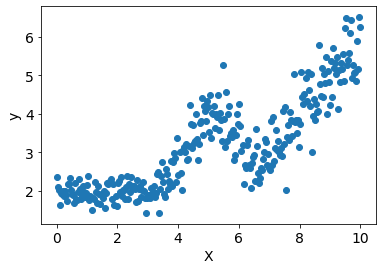

In [5]:
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y');

# 2. Train a single decision tree

In [6]:
rg1 = DecisionTreeRegressor(max_depth=1, random_state=1)
rg1.fit(X, y)
y_pred_1 = rg1.predict(X)

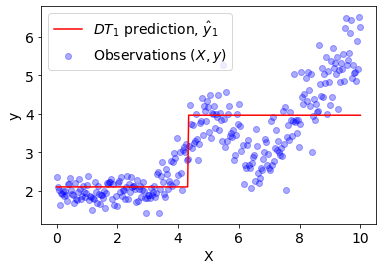

In [7]:
# Plot
plt.scatter(X, y, label='Observations $(X, y)$', alpha=.33, c='b')
plt.xlabel('X')
plt.ylabel('y');
plt.plot(X, y_pred_1, c='r', label='$DT_1$ prediction, $\hat{y}_1$');
plt.legend();

## 2.1 What are the errors of this prediction?

The answer is simple ^_^ : 
$$y - \hat{y}_1$$

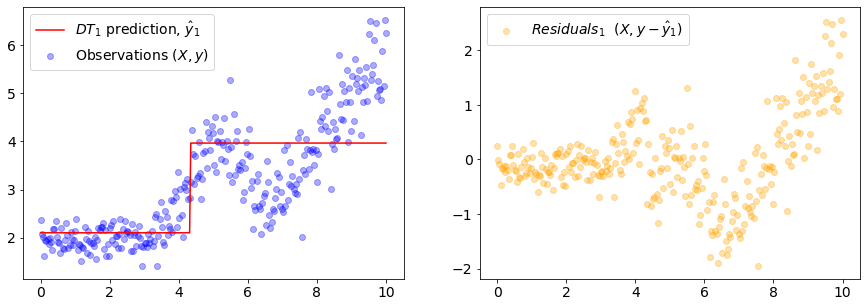

In [8]:
# Plot

fig,ax=plt.subplots(1,2, figsize=(15,5))

ax[0].scatter(X, y, label='Observations $(X, y)$', alpha=.33, c='b')
ax[0].plot(X, y_pred_1, c='r', label='$DT_1$ prediction, $\hat{y}_1$')
ax[0].legend()

ax[1].scatter(X, y - y_pred_1, label='$Residuals_1\ \  (X, y - \hat{y}_1)$', c='orange', alpha=.33);
ax[1].legend();

In [9]:
mean_squared_error(y, y_pred_1)

0.618936499767771

# 3. Train second decision tree

But now instead of the original target $y$ we will **predict the residuals** of the first model:
$$(X, y-\hat{y_1})$$

In [10]:
rg2 = DecisionTreeRegressor(max_depth=1, random_state=1)
rg2.fit(X, y-y_pred_1)
y_pred_2 = rg2.predict(X)

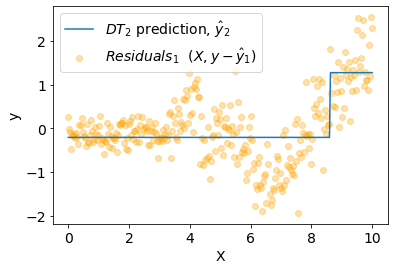

In [11]:
# Plot
plt.scatter(X, y-y_pred_1,  c='orange', alpha=.33, label='$Residuals_1\ \  (X, y - \hat{y}_1)$')
plt.xlabel('X')
plt.ylabel('y');
plt.plot(X, y_pred_2, label='$DT_2$ prediction, $\hat{y}_2$');
plt.legend();

## What are the total errors of this prediction?

The answer is even simpler: 
$$y - \hat{y}_1 - \hat{y}_2$$

##  Apply sequentially $DT_1$ and $DT_2$

- $\hat{y_1}$ is an estimation of $y$
- $\hat{y_2}$ is an estimation of $y - \hat{y_1}$

- *therefore* $\hat{y_1} + \hat{y_2}$ is a better estimation of $y$

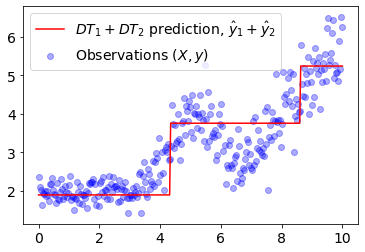

In [12]:
plt.scatter(X, y, label='Observations $(X, y)$', alpha=.33, c='b')
plt.plot(X, y_pred_1 + y_pred_2, c='r', label='$DT_1 + DT_2$ prediction, $\hat{y}_1 + \hat{y}_2$')
plt.legend();

In [13]:
mean_squared_error(y, y_pred_1+y_pred_2)

0.35391413627071694

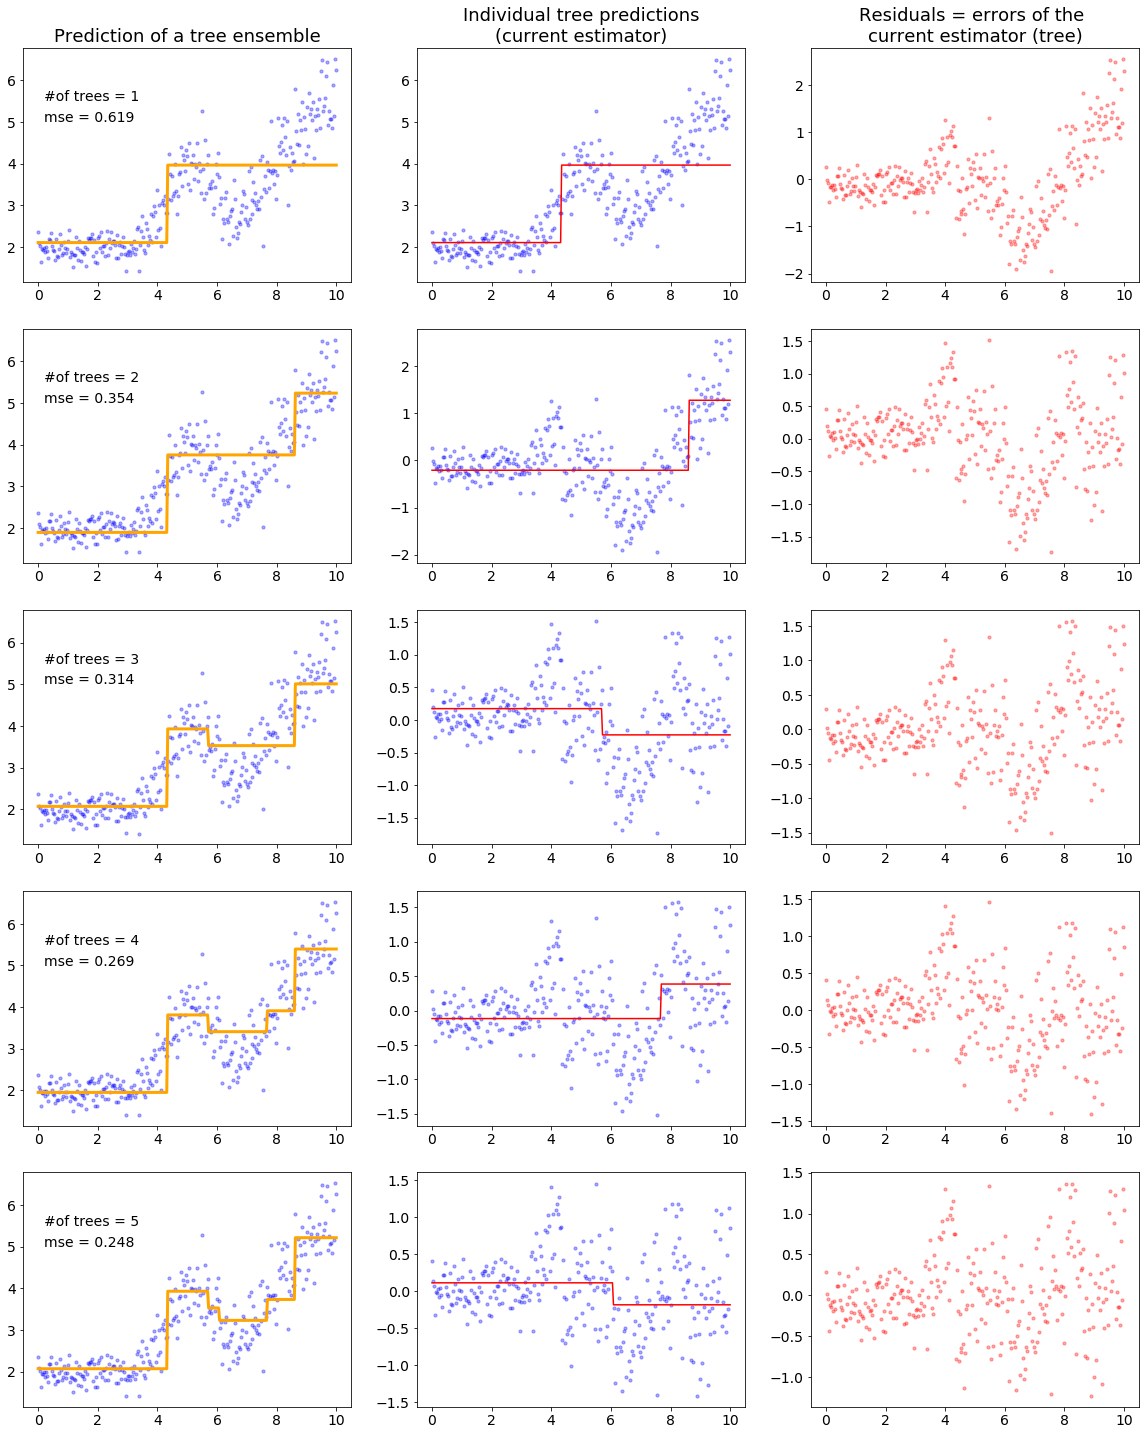

In [14]:
test = plot_boosting_results(X, y, 5)

# 4. Gradient Boosting (idea)



1. Train decision tree $dt_1$ on the data $(X, y)$
2. Make a prediction $\hat{y}_1 = dt_1(X)$
3. Train another decision tree $dt_2$ on the errors of the $dt_1$: $(X, y-\hat{y}_1)$
4. Make a prediction $\hat{y}_2 = dt_2(X)$. Second decision tree is trying to reduce the errors of the first one.
5. Predict $y$ as the sum of $\hat{y}_1$ and $\hat{y}_2$

instead of 2 trees, train $k$ trees sequentially and predict target variable as their sum:
$$y = \hat{y}_1 + \hat{y}_2 + \hat{y}_3 + \ldots + \hat{y}_k$$

On practice people are using a weighted ($\alpha < 1$) sum, thus each subsequent tree has less contribution to the ensemble.

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
gbt = GradientBoostingRegressor(n_estimators=5, learning_rate=1, max_depth=1)

gbt.fit(X,y)
y_pred = gbt.predict(X)

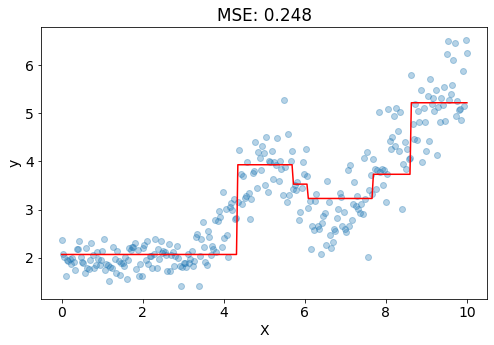

In [17]:
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=.33)
plt.xlabel('X')
plt.ylabel('y');
plt.plot(X, y_pred, c='r')
plt.title(f'MSE: {mse(y, y_pred)}');

In [18]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=997)

## 4.1 Number of trees

In [20]:
train_mse = []
test_mse = []

n_trees = range(1, 100)

for i in tqdm(n_trees):
    gbt = GradientBoostingRegressor(n_estimators=i, learning_rate=.75, max_depth=1)
    gbt.fit(X_train, y_train)
    
    y_pred_train = gbt.predict(X_train)
    y_pred_test = gbt.predict(X_test)
    
    train_mse.append(mse(y_train, y_pred_train))
    test_mse.append(mse(y_test, y_pred_test))

100%|██████████| 99/99 [00:01<00:00, 85.69it/s] 


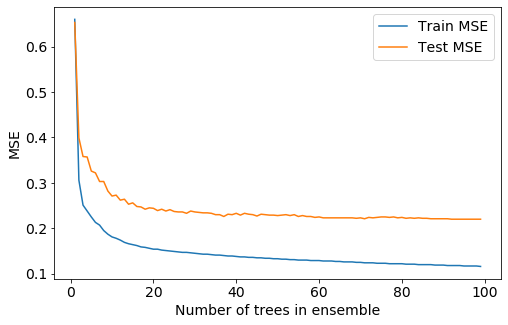

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(n_trees, train_mse, label='Train MSE')
plt.plot(n_trees, test_mse, label='Test MSE')
plt.xlabel('Number of trees in ensemble')
plt.ylabel('MSE')
plt.legend();

## 4.2 Depth of the trees

In [22]:
train_mse = []
test_mse = []

depth = range(1, 20)

for d in tqdm(depth):
    gbt = GradientBoostingRegressor(n_estimators=10, learning_rate=.1, max_depth=d)
    gbt.fit(X_train, y_train)
    
    y_pred_train = gbt.predict(X_train)
    y_pred_test = gbt.predict(X_test)
    
    train_mse.append(mse(y_train, y_pred_train))
    test_mse.append(mse(y_test, y_pred_test))

100%|██████████| 19/19 [00:00<00:00, 199.86it/s]


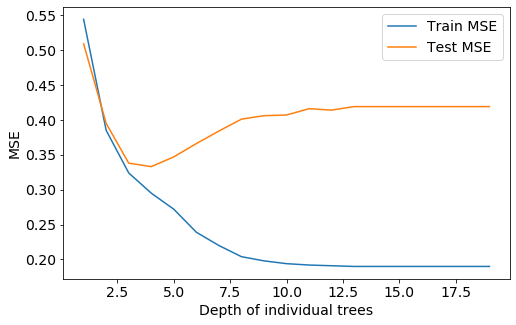

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(depth, train_mse, label='Train MSE')
plt.plot(depth, test_mse, label='Test MSE')
plt.xlabel('Depth of individual trees')
plt.ylabel('MSE')
plt.legend();

## Tuning hyperparameters of a GBT

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

## Tutorial on GBT

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3885826/
